In [5]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
import colorcet
import matplotlib as mpl
from astropy.table import QTable

plt.style.use('paper.mplstyle')

In [6]:
def get_hist(data, bins=None, nbins=50, logbins=False, norm=True, cum=False):

    """Get histogram

    Parameters
    ----------
    data : np.array
        input data
    bins : list
        input bin edges for histogram calculaiton; default=''
    nbins : int
        number of bins to determine if bins is not given; defult=50
    logbins : bool
        logarithmically spaced bins if bins is not given
    norm : bool
        normalise such that max is equal to unity; default=True
    cum : bool
        cumulative distorbution; otherwise probability distorbution
    Returns
    -------
    bins : list
        bin edges for histogram calculaiton
    bin_cent : np.array
        bin centres, for easy plotting in matplotlib
    hist : np.array
        histogram data for each bin centre
    """

    data = data.flatten()

    if bins.all() is None:
        vmin=np.nanmin(data)
        vmax=np.nanmax(data)

        bmin = vmin - (np.absolute(vmin)*1)
        bmax = vmax + (np.absolute(vmax)*0.3)

        if logbins:
            min = np.nanmin(data[data>0])
            bins = np.logspace(np.log10(bmin), np.log10(bmax), nbins+1)
        else:
            bins = np.linspace(bmin, bmax, nbins+1)
    else:
        nbins = len(bins)-1

    bins_cent = np.empty([nbins])

    for i in range(nbins):
        bins_cent[i] = np.nanmean([bins[i], bins[i+1]])

    hist = np.histogram(data.flatten(), bins)[0]

    if cum:
        hist = np.cumsum(hist)
    if norm:
        hist = hist/np.nanmax(hist)

    return(bins, bins_cent, hist)

In [7]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)
table

gal_name,region_ID,hstcat_region_ID,_idx,area_ellipse,area_exact,HA6562_FLUX_HST,major_sigma,minor_sigma,position_angle,mean_sigma,x_cen,y_cen,radius_trunk,radius_trunkclose,major_fwtm,minor_fwtm,mean_fwtm,mean_hwtm,major_fwhm,minor_fwhm,mean_fwhm,mean_hwhm,min_npix,min_value_sig,min_delta_sig,radius_trunk_pc,radius_trunkclose_pc,major_fwtm_pc,minor_fwtm_pc,mean_fwtm_pc,mean_hwtm_pc,major_fwhm_pc,minor_fwhm_pc,mean_fwhm_pc,mean_hwhm_pc,ra_cen,dec_cen,mean_sigma_pc,x_max,y_max,ra_max,dec_max,flag_edge_hst,cen_x,cen_y,cen_ra,cen_dec,cen_x_geo,cen_y_geo,flag_edge,flag_nearby,flag_star,deproj_dist,deproj_phi,region_area,region_circ_rad,HB4861_FLUX,OIII5006_FLUX,HA6562_FLUX,NII6583_FLUX,SII6716_FLUX,SII6730_FLUX,SIII9068_FLUX,OI6300_FLUX,NII5754_FLUX,HEI5875_FLUX,SIII6312_FLUX,OI6363_FLUX,OII7319_FLUX,OII7330_FLUX,HB4861_FLUX_ERR,OIII5006_FLUX_ERR,HA6562_FLUX_ERR,NII6583_FLUX_ERR,SII6716_FLUX_ERR,SII6730_FLUX_ERR,SIII9068_FLUX_ERR,OI6300_FLUX_ERR,NII5754_FLUX_ERR,HEI5875_FLUX_ERR,SIII6312_FLUX_ERR,OI6363_FLUX_ERR,OII7319_FLUX_ERR,OII7330_FLUX_ERR,HA6562_SIGMA,NII6583_SIGMA,OIII5006_SIGMA,HA6562_VEL,NII6583_VEL,OIII5006_VEL,HA6562_SIGMA_ERR,NII6583_SIGMA_ERR,OIII5006_SIGMA_ERR,HA6562_VEL_ERR,NII6583_VEL_ERR,OIII5006_VEL_ERR,HB4861_FLUX_CORR,OIII5006_FLUX_CORR,HA6562_FLUX_CORR,NII6583_FLUX_CORR,SII6716_FLUX_CORR,SII6730_FLUX_CORR,SIII9068_FLUX_CORR,OI6300_FLUX_CORR,NII5754_FLUX_CORR,HEI5875_FLUX_CORR,SIII6312_FLUX_CORR,OI6363_FLUX_CORR,OII7319_FLUX_CORR,OII7330_FLUX_CORR,HB4861_FLUX_CORR_ERR,OIII5006_FLUX_CORR_ERR,HA6562_FLUX_CORR_ERR,NII6583_FLUX_CORR_ERR,SII6716_FLUX_CORR_ERR,SII6730_FLUX_CORR_ERR,SIII9068_FLUX_CORR_ERR,OI6300_FLUX_CORR_ERR,NII5754_FLUX_CORR_ERR,HEI5875_FLUX_CORR_ERR,SIII6312_FLUX_CORR_ERR,OI6363_FLUX_CORR_ERR,OII7319_FLUX_CORR_ERR,OII7330_FLUX_CORR_ERR,EBV,EBV_ERR,met_scal,met_scal_err,logq_D91,logq_D91_err,t_N2,t_S3,t_N2_err,t_S3_err,BPT_NII,BPT_SII,BPT_OI,LOG_SIGMA_SFR_CHAB,LOG_SIGMA_STMASS_CHAB,5thNN_dist,NN_number,Environment,r_R25,r_reff,Lum_HA6562_CORR,Delta_met_scal,pc_per_pixel,EW_HA6562_raw,EW_HA6562_raw_ERR,EW_HB4861_raw,EW_HB4861_raw_ERR,EW_HA6562_fit,EW_HA6562_fit_ERR,EW_HB4861_fit,EW_HB4861_fit_ERR,EW_HA6562_bgcorr,EW_HA6562_bgcorr_ERR,EW_HB4861_bgcorr,EW_HB4861_bgcorr_ERR,HII_class_v2,HII_class_v3,HA6562_FLUX_HST_CORR,HA6562_LUMINOSITY_HST,region_circ_rad_pc,flag_nearby_hst
,,,,arcsec2,arcsec2,erg / (s cm2),arcsec,arcsec,deg,arcsec,pix,pix,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,,,,pc,pc,pc,pc,pc,pc,pc,pc,pc,pc,deg,deg,pc,pix,pix,deg,deg,,pix,pix,deg,deg,pix,pix,,,,arcsec,rad,pix2,arcsec,1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),mag,mag,,,,,K,K,K,K,,,,solMass / (yr kpc2),solMass / kpc2,pc,,,,,erg / s,,pc,,,,,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,,,erg / (s cm2),erg / s,pc,
bytes32,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,i

In [8]:
mask_flags = ~((table['flag_edge_hst']==1)|(table['flag_edge']==1)|(table['flag_star']==1))
table = table[mask_flags]

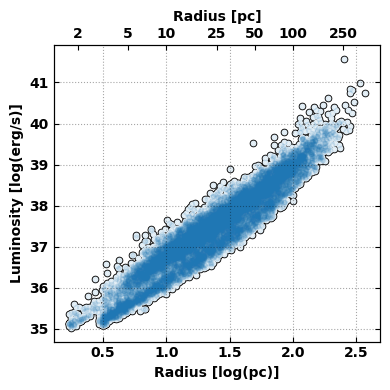

In [9]:
mask_hiiregion = table['HII_class_v3'] == True

data_x = np.log10(table['radius_trunkclose_pc'].value[mask_hiiregion])
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value[mask_hiiregion])

fig = plt.figure(figsize=(4, 4)) 

ax = fig.add_subplot(111)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax.scatter(data_x, data_y, s=10, alpha=0.1)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius [log(pc)]')
ax.set_ylabel('Luminosity [log(erg/s)]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([2,5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radlum_all.pdf', dpi=200, bbox_inches='tight')

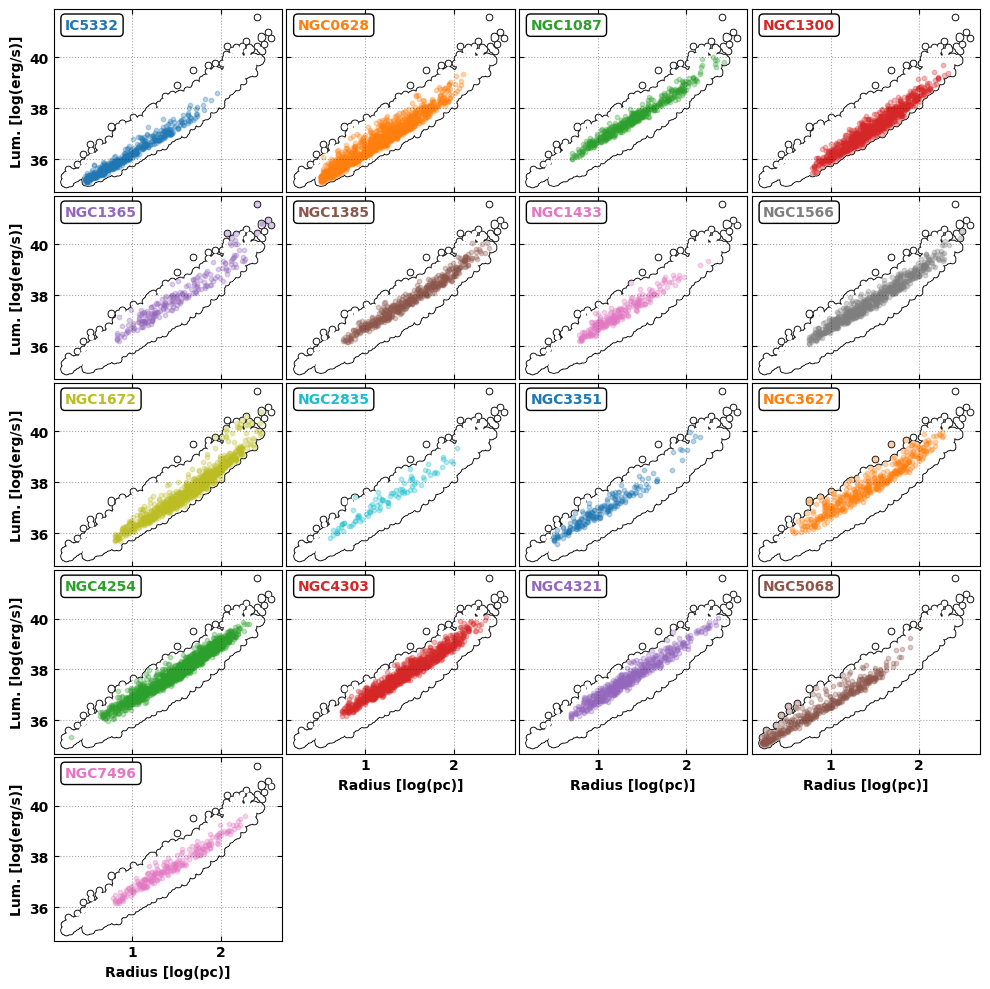

In [10]:
mask_hiiregion = table['HII_class_v3'] == True

table_ = table[mask_hiiregion]

data_x = np.log10(table_['radius_trunkclose_pc'].value)
data_y = np.log10(table_['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table_['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3)

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [13,14,15,16]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_sep.pdf', dpi=150, bbox_inches='tight')

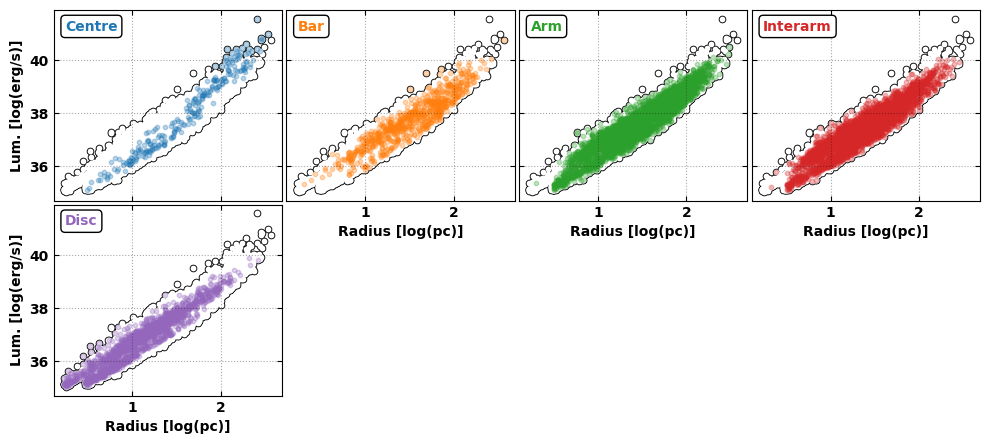

In [11]:
mask_hiiregion = table['HII_class_v3'] == True

table_ = table[mask_hiiregion]

data_x = np.log10(table_['radius_trunkclose_pc'].value)
data_y = np.log10(table_['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(10, 10)) 

# environments = np.unique(table['Environment'])
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']

for i, environment in enumerate(environments):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_env = sum(([table_['Environment'] == env for env in environment])) == 1

    data_x_, data_y_ = data_x[mask_env], data_y[mask_env]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3)

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, environments_names[i], ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [1,2,3,4]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_env.pdf', dpi=150, bbox_inches='tight')